# Conditional pix2pix GAN
### Adapted from [ericklindernoren](https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py)
### [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf)

## TODO:
1. Set up a github repository.
2. Write a log file for each run that includes the date, name of experiment, details of parameter values, and metrics after each epoch (loss, time, etc.). This is particularly important since it is apparently impossible to see output from a Jupyter notebook if connection to the server is ever lost while it's running.
3. Output should be both displayed in the notebook and saved to a folder and should include:
  - Loss curves (should get overwritten in the output folder after each epoch, so just one image)
  - Example outputs: for several training images, show several generated images (different noise inputs). Also show generated examples for test set examples to give a feel for generalization/overfitting.
4. Make a new synthetic dataset with random number of circles (say 1-5) per image, each of which is a random color (choose from among several color options). Use LAB colorspace to generate the circles to ensure that all circles have the same L value before converting to RGB to save.
5. Consider if a different "real" data set (e.g., hotel interiors) would be better than the current set of color images to show multimodality.
6. Prediction: the GAN will learn to ignore noise input, so that generated images look similar for a given conditional input (L channel) even with different noise.
7. Try to increase diversity by generating a set number of possible outputs (i.e., more channels); check out this paper: [Photographic Image Synthesis with Cascaded Refinement Networks](https://arxiv.org/pdf/1707.09405.pdf).
8. Think about evaluation metrics, user study?
9. Potential final comparisons for paper:
  - U-NET with L2 loss (i.e., just the generator with no GAN, no noise)
  - GAN with no noise
  - GAN with noise
  - GAN with diversity improvement


In [1]:
import time

start = time.time()

def sec_to_time(seconds):
    hours = seconds // (60 * 60)
    seconds -= hours * (60 * 60)
    minutes = seconds // 60
    seconds -= minutes * 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

In [2]:
import os

generic_output_folder = "Output/"
new_output_folder = "Colorization_pix2pix/"
save_path = generic_output_folder + new_output_folder

# Ensure output can save in desired location
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [3]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

from PIL import Image
from tqdm import tnrange, tqdm_notebook, tqdm
import cv2
import random


Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [4]:
def list_image_files(directory):
    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_image_file(f)]

def is_an_image_file(filename):
    IMAGE_EXTENSIONS = ['.png', '.jpg', '.jpeg']
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False

In [5]:
def load_image(path):
    img = cv2.imread(path[0])
    return img

def load_images(path, n_images):
    if n_images < 0:
        n_images = float("inf")
    all_image_paths = list_image_files(path)
    images_l, images_ab = [], []
    
    # Initialize a progress bar with max of n_images
    pbar = tqdm_notebook(total = n_images, desc="Loading Images...")
    
    for path in zip(all_image_paths):
        img = load_image(path)
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab_img = preprocess_image(lab_img)
        
        l = lab_img[:,:,0]
        l = l[:,:,np.newaxis]
        # Include all 3 channels, overwrite 1st channel with 0's
        ab = lab_img[:,:,1:]

        images_l.append(l)
        images_ab.append(ab)

        images_loaded = len(images_l)
        
        # Increase progress by one
        pbar.update(1)
        
        if images_loaded > n_images - 1: 
            break

    return {
        'l': np.array(images_l),
        'ab': np.array(images_ab)
    }

In [6]:
RESHAPE = (256,256)

def preprocess_image(cv_img):
    img = (cv_img - 127.5) / 127.5
    return img

def deprocess_image(img):
    img = (img * 127.5) + 127.5
    return img.astype('uint8')

In [7]:
def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)

In [8]:
def sample_images(truth, gray, predicted, n_to_sample, shouldSave, epoch):
    predicted = predicted.astype(np.float64)
    
    grays_merged = []
    truth_merged = []
    predicted_merged = []
    for i in range(n_to_sample):
        newImageIndex = i * 2
        grays_merged.append(cv2.merge((gray[newImageIndex], gray[newImageIndex], gray[newImageIndex])))
        truth_merged.append(cv2.merge((gray[newImageIndex], truth[newImageIndex])))
        predicted_merged.append(cv2.merge((gray[newImageIndex], predicted[newImageIndex])))
    
    r = truth.shape[1]
    c = truth.shape[2]

    figure = np.zeros([r * n_to_sample + 15 * (n_to_sample-1), c * 3 + 5 * (3-1), 3], dtype=np.uint8)
    figure += 255
    start_r = 0
    
    for i in range(n_to_sample):        
        figure[start_r:start_r + r, :c] = cv2.cvtColor(deprocess_image(truth_merged[i]), cv2.COLOR_LAB2RGB)
        figure[start_r:start_r + r, c + 5:2*(c)+5] = deprocess_image(grays_merged[i])
        figure[start_r:start_r + r, 2*(c+5):3*c + 5*2] = cv2.cvtColor(deprocess_image(predicted_merged[i]), cv2.COLOR_LAB2RGB)
        start_r += r + 15
    img = Image.fromarray(figure, "RGB")
    
    dpi = plt.rcParams['figure.dpi']
    height, width, _ = figure.shape

    preview = plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis("off")
    title = "Epoch " + str(epoch)
    plt.title(title, fontsize = 'large')
    
    plt.show()
    
    if shouldSave:
        # What size does the figure need to be in inches to fit the image?
        figsize = width / float(dpi), height / float(dpi)
        
        full = plt.figure(figsize = figsize)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title, fontsize = 25)
        plt.savefig(save_path + str(epoch) + ".png")
        plt.close()

In [9]:
def get_generator(H, W):
    # Inputs: height and width of the input image
    # Returns the model, which generates the AB channels

    # Pix2pix adapted from 
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def conv2d(layer_input, filters, f_size=4, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    gf = 64 # Number of filters in the first layer of G

    noise_in = Input(shape=(100,))
    condition_in = Input(shape=(H, W, 1))
    
    # pass noise through a FC layer to get it to the right size
    noise = Dense(H * H)(noise_in)

    # reshape to be the size of an image channel
    noise = Reshape((H, H, 1))(noise)
    
    # stick the (somewhat modified) noise as the second channel after
    # the gray input. Assuming new dimension of hid will be
    # B x 256 x 256 x 2, where B is the batch size.
    d0 = Concatenate(axis=-1)([condition_in, noise])

    # U-NET
    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Upsampling
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8)
    u3 = deconv2d(u2, d4, gf*8)
    u4 = deconv2d(u3, d3, gf*4)
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    
    # Final 2-channel AB image with values between -1 and 1
    img_out = Conv2D(2, kernel_size=4, strides=1, padding='same', activation='tanh', name='pred_ab')(u7)

    # Make Model
    model = Model(inputs=[noise_in, condition_in], outputs=img_out)
    
    # Show summary of layers
    print("Generator Model:")
    model.summary()

    return model


In [10]:
def get_discriminator(H, W):
    # Inputs: height and width of the input image
    # Returns the model, which predicts real/fake
    # over a set of spatial regions (i.e., predicts a matrix instead of a scalar).

    # Pix2pix adapted from 
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    # Number of filters in the first layer of D
    df = 64

    img_in = Input(shape=(H, W, 2)) # AB channels
    condition_in = Input(shape=(H, W, 1)) # L channel
    
    # Concat the L and AB channels
    concat_imgs = Concatenate()([condition_in, img_in])

    d1 = d_layer(concat_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    # validity map is a one-channel matrix 1/16 the size of the input (halved 4 times).
    # Each number predicts whether a region of the input is real/fake.
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same', name='pred_valid')(d4)

    # Build Model
    model = Model(inputs=[img_in, condition_in], outputs=validity)

    # Show summary of layers
    print("Disciminator Model:")
    model.summary()

    return model


In [11]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def show_samples(batchidx, save_path):
    fig, axs = plt.subplots(5, 6, figsize=(10,6))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    #fig, axs = plt.subplots(5, 6)
    #fig.tight_layout()
    for classlabel in range(10):
        row = int(classlabel / 2)
        coloffset = (classlabel % 2) * 3
        lbls = one_hot_encode([classlabel] * 3)
        noise = generate_noise(3, 100)
        gen_imgs = generator.predict([noise, lbls])

        for i in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[i], scale=True)
            axs[row,i+coloffset].imshow(img)
            axs[row,i+coloffset].axis('off')
            if i ==1:
                axs[row,i+coloffset].set_title(tags[classlabel])
    plt.savefig(save_path + '.jpg')
    plt.show()
    plt.close()

In [12]:
def plot_losses(g_losses, d_losses, epoch_num):
    # Scale axis so it lines up with epoch_num
    x_axis = [epoch_num * x / (len(g_losses) - 1) for x in range(len(g_losses))]
    
    ax = subplot(1,1,1)
    ax.plot(x_axis, g_losses, label="Generator")
    ax.plot(x_axis, d_losses, label="Discriminator")
    plt.title("Losses After " + str(epoch_num) + " Epochs")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.savefig(save_path + "Losses.jpg")
    plt.show()

In [13]:
BATCH_SIZE = 6
n_images = 100    # Number of images to load for training; recommended = 512

# Get training images
# Load dataset, convert to LAB, normalize to range [-1, 1]
#data = load_images('../Colorization_GAN/color_images/Train', n_images)
data = load_images('/home/drew/Colorization_GAN/circle_pairs/train', n_images)

# Separate into inputs (X) and outputs (Y)
y_train, X_train = data['ab'], data['l']

num_batches = X_train.shape[0] // BATCH_SIZE


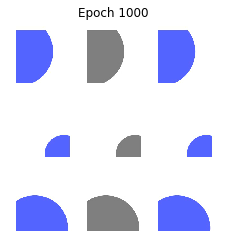

In [14]:
sample_images(y_train, X_train, y_train, 3, False, 1000)

In [15]:
# GAN creation
H = W = 256

# Discriminator loss - MSE seems to produce better results
#discrim_loss = 'binary_crossentropy'
discrim_loss = 'mse'

# 1. Discriminator
# Calculate output shape of D (PatchGAN)
patch = H // 2**4 # Input size gets cut in half 4 times
disc_patch = (patch, patch, 1)
discriminator = get_discriminator(H, W)
discriminator.name = 'discrim_model' # Need a name for the loss dictionary below
discriminator.compile(optimizer=Adam(2e-4, 0.5), loss=discrim_loss, metrics=['accuracy'])
discriminator.trainable = False # For the combined model we will only train the generator
print("\n")

# 2. Generator
generator = get_generator(H, W)
generator.name = 'gen_model' # Need a name for the loss dictionary below

# 3. GAN
gan_noise_in = Input(shape=(100,))
gan_condition_in = Input(shape=(H, W, 1))

# By conditioning on L generate a fake version of AB
fake_AB = generator([gan_noise_in, gan_condition_in])

# Discriminator determines validity of AB images / L pairs
valid = discriminator([fake_AB, gan_condition_in])

losses = {'gen_model': 'mae',
          'discrim_model': discrim_loss}
loss_weights = {'gen_model': 100.0, 'discrim_model': 1.0}

gan = Model(inputs=[gan_noise_in, gan_condition_in], outputs=[fake_AB, valid])
gan.compile(optimizer=Adam(2e-4, 0.5), loss=losses, loss_weights=loss_weights)
gan.summary()

Disciminator Model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 3)  0           input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 3136        concatenate_1[0][0]     

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
gen_model (Model)               (None, 256, 256, 2)  48459394    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
discrim_model (Model)           (None, 16, 16, 1)    2768321     gen_model[1][0]                  
          

/home/scott/anaconda3/envs/tf-gpu-cuda9/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0001, Gen Loss: 48.0764, Discrim Loss: 4.0410, Discrim Acc: 0.3456


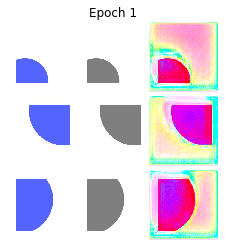

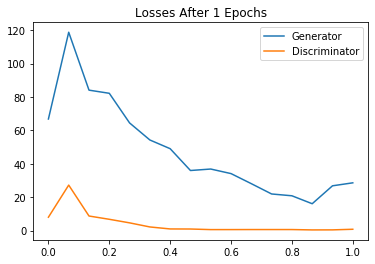

Epoch: 0002, Gen Loss: 16.1148, Discrim Loss: 0.4015, Discrim Acc: 0.5643


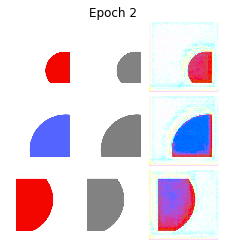

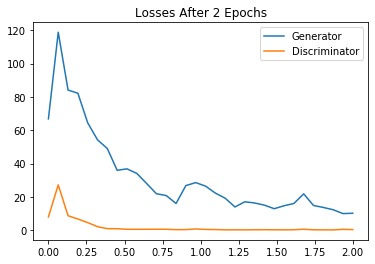

Epoch: 0003, Gen Loss: 11.1202, Discrim Loss: 0.2776, Discrim Acc: 0.6350


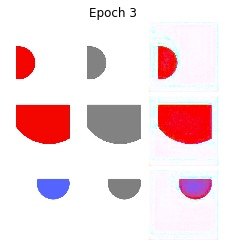

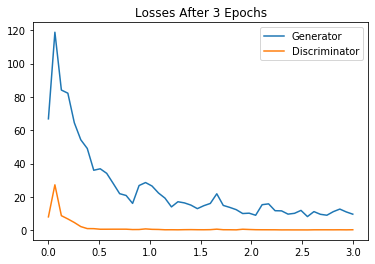

Epoch: 0004, Gen Loss: 10.9059, Discrim Loss: 0.3253, Discrim Acc: 0.6174


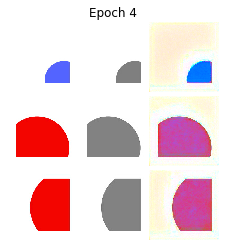

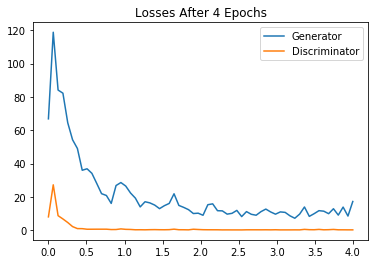

Epoch: 0005, Gen Loss: 9.0131, Discrim Loss: 0.2055, Discrim Acc: 0.7234


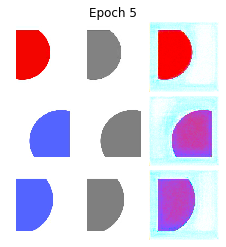

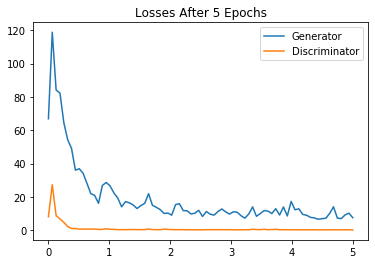

Epoch: 0006, Gen Loss: 8.3010, Discrim Loss: 0.2173, Discrim Acc: 0.7296


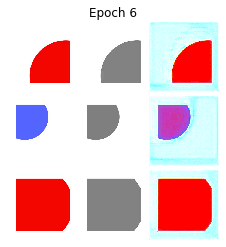

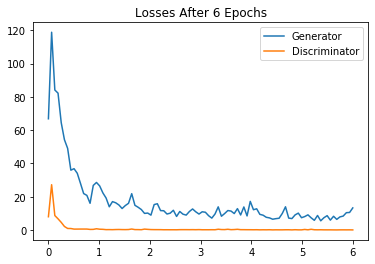

Epoch: 0007, Gen Loss: 7.8020, Discrim Loss: 0.2470, Discrim Acc: 0.6986


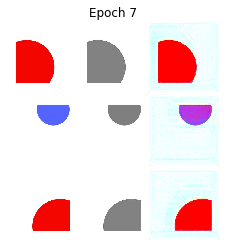

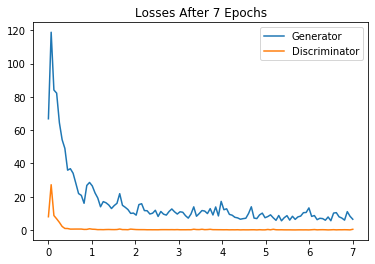

Epoch: 0008, Gen Loss: 8.0762, Discrim Loss: 0.2157, Discrim Acc: 0.7315


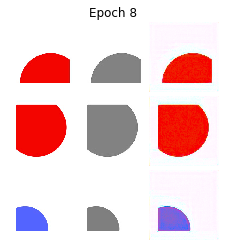

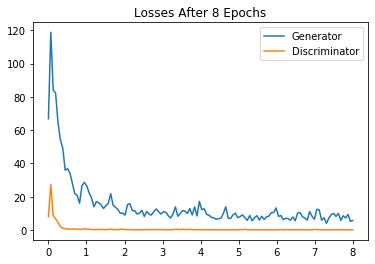

Epoch: 0009, Gen Loss: 10.3164, Discrim Loss: 0.7743, Discrim Acc: 0.5374


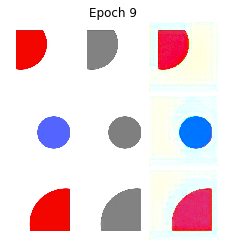

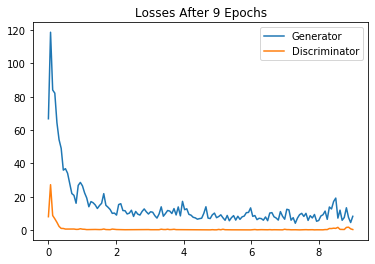

Epoch: 0010, Gen Loss: 8.3006, Discrim Loss: 0.2748, Discrim Acc: 0.6437


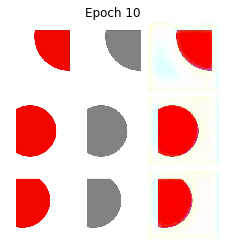

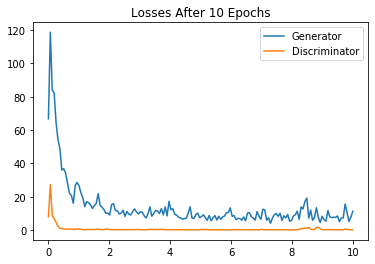

Epoch: 0011, Gen Loss: 8.5412, Discrim Loss: 0.1579, Discrim Acc: 0.7910


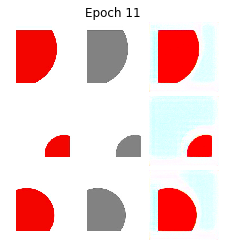

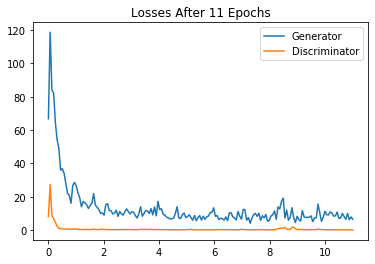

Epoch: 0012, Gen Loss: 7.1711, Discrim Loss: 0.1531, Discrim Acc: 0.8061


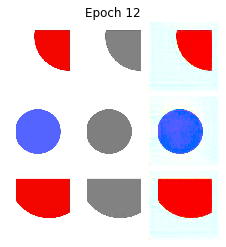

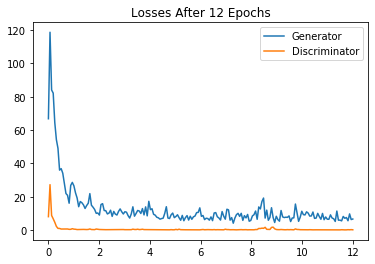

Epoch: 0013, Gen Loss: 7.4233, Discrim Loss: 0.1330, Discrim Acc: 0.8592


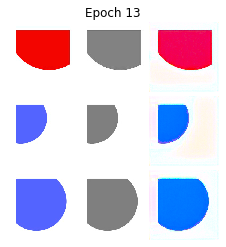

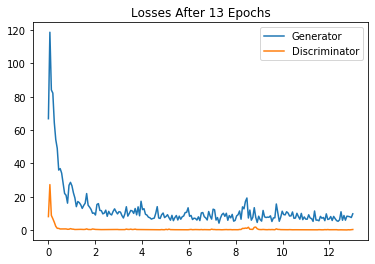

Epoch: 0014, Gen Loss: 7.8900, Discrim Loss: 0.1591, Discrim Acc: 0.8166


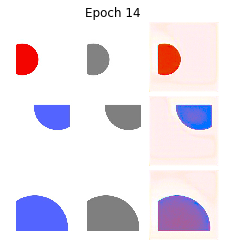

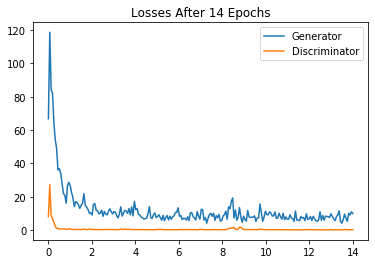

Epoch: 0015, Gen Loss: 9.5466, Discrim Loss: 0.1429, Discrim Acc: 0.8488


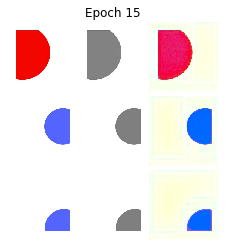

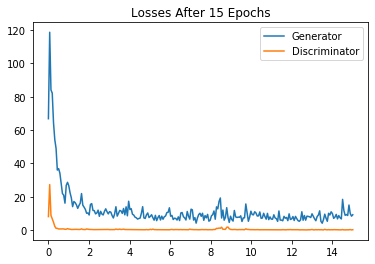

Epoch: 0016, Gen Loss: 7.0555, Discrim Loss: 0.1201, Discrim Acc: 0.8607


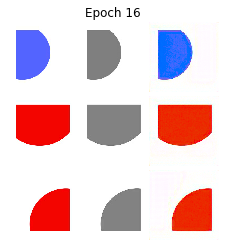

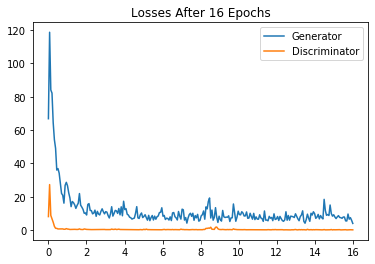

Epoch: 0017, Gen Loss: 7.9508, Discrim Loss: 0.3453, Discrim Acc: 0.6791


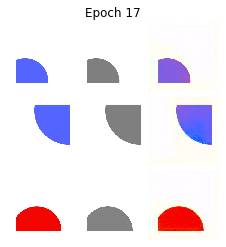

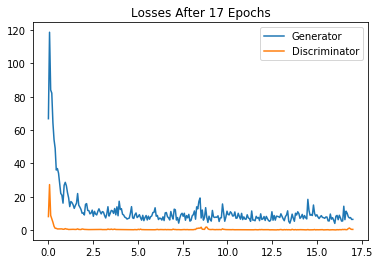

Epoch: 0018, Gen Loss: 8.3919, Discrim Loss: 0.1376, Discrim Acc: 0.8467


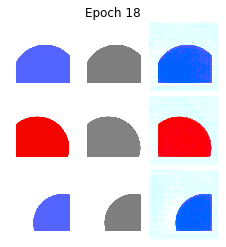

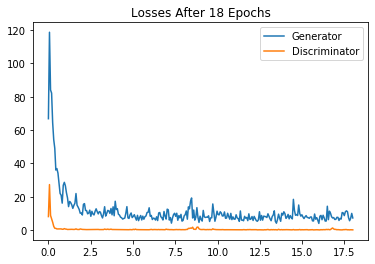

Epoch: 0019, Gen Loss: 8.6621, Discrim Loss: 0.0899, Discrim Acc: 0.9023


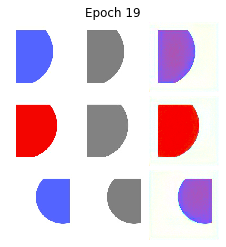

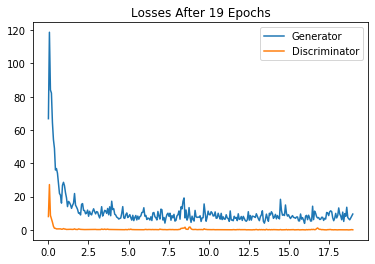

Epoch: 0020, Gen Loss: 6.3146, Discrim Loss: 0.1009, Discrim Acc: 0.8998


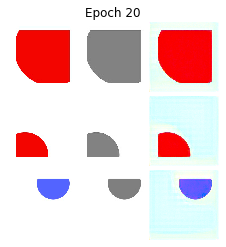

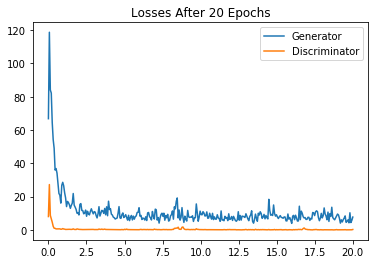

Epoch: 0021, Gen Loss: 7.4120, Discrim Loss: 0.1387, Discrim Acc: 0.8606


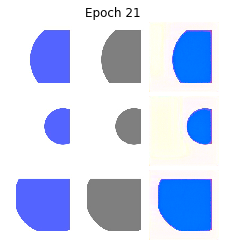

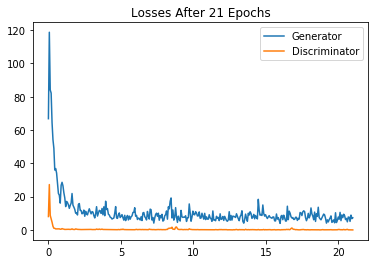

Epoch: 0022, Gen Loss: 6.6744, Discrim Loss: 0.1450, Discrim Acc: 0.8433


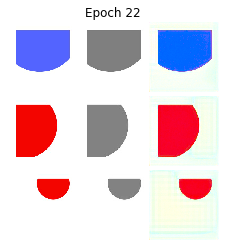

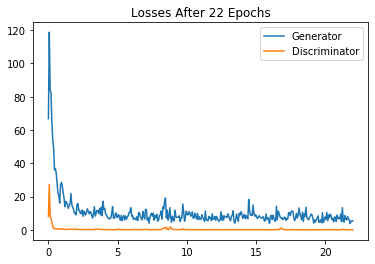

Epoch: 0023, Gen Loss: 6.9564, Discrim Loss: 0.0776, Discrim Acc: 0.9318


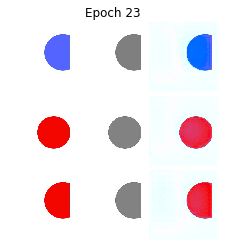

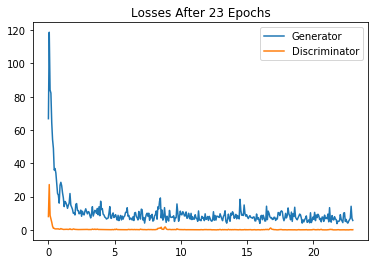

Epoch: 0024, Gen Loss: 6.4836, Discrim Loss: 0.0628, Discrim Acc: 0.9491


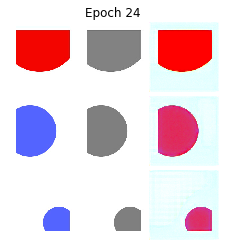

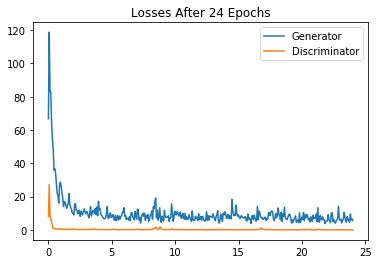

Epoch: 0025, Gen Loss: 7.8177, Discrim Loss: 0.0613, Discrim Acc: 0.9457


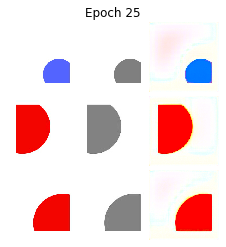

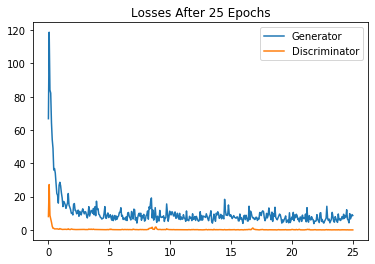

Epoch: 0026, Gen Loss: 7.1056, Discrim Loss: 0.1269, Discrim Acc: 0.8657


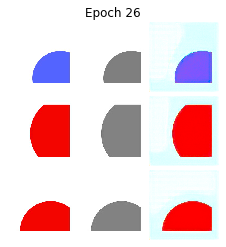

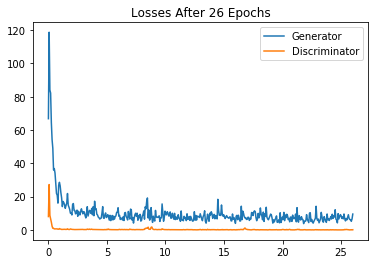

Epoch: 0027, Gen Loss: 7.8894, Discrim Loss: 0.1211, Discrim Acc: 0.8770


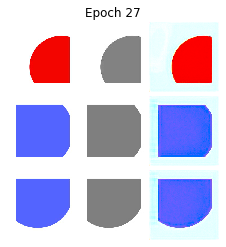

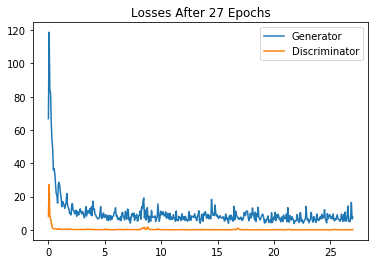

Epoch: 0028, Gen Loss: 7.7851, Discrim Loss: 0.1271, Discrim Acc: 0.8691


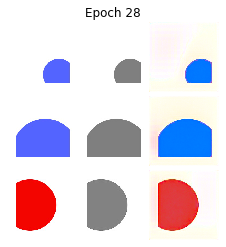

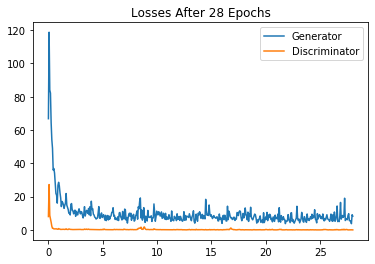

Epoch: 0029, Gen Loss: 5.9880, Discrim Loss: 0.0319, Discrim Acc: 0.9848


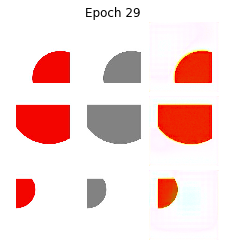

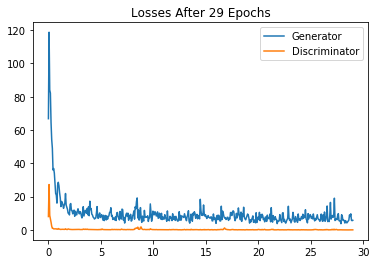

Epoch: 0030, Gen Loss: 7.5466, Discrim Loss: 0.1064, Discrim Acc: 0.8965


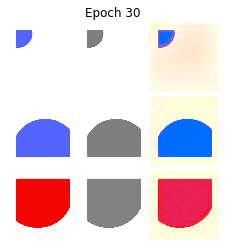

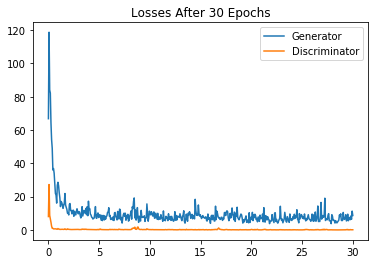

Epoch: 0031, Gen Loss: 7.9468, Discrim Loss: 0.0602, Discrim Acc: 0.9491


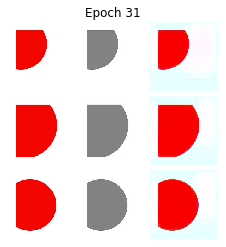

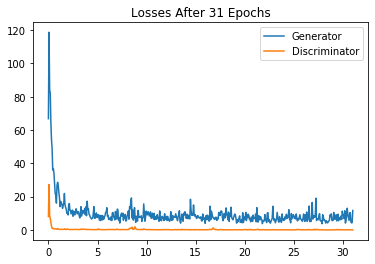

Epoch: 0032, Gen Loss: 7.9102, Discrim Loss: 0.1881, Discrim Acc: 0.8027


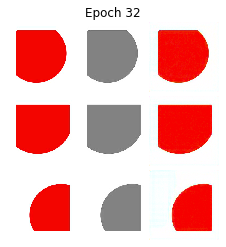

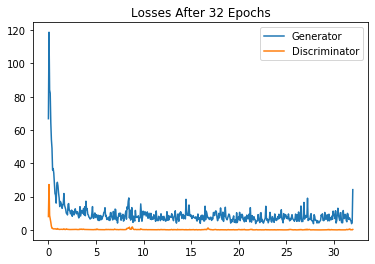

Epoch: 0033, Gen Loss: 7.2672, Discrim Loss: 0.1317, Discrim Acc: 0.8643


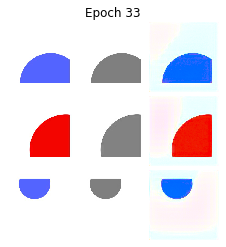

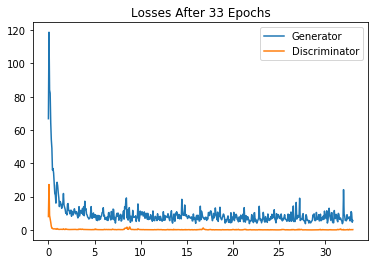

Epoch: 0034, Gen Loss: 7.7739, Discrim Loss: 0.0990, Discrim Acc: 0.8858


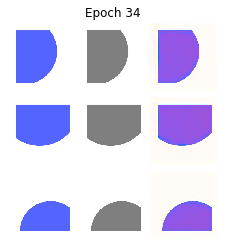

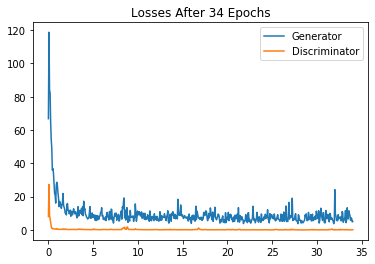

Epoch: 0035, Gen Loss: 5.9675, Discrim Loss: 0.0798, Discrim Acc: 0.9176


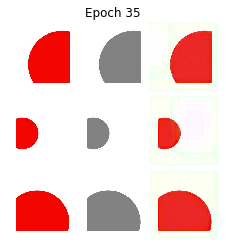

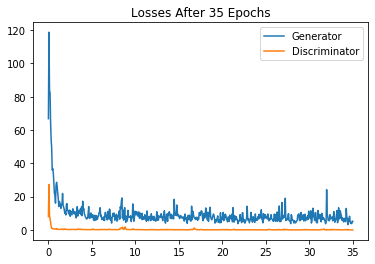

Epoch: 0036, Gen Loss: 7.4420, Discrim Loss: 0.3132, Discrim Acc: 0.7249


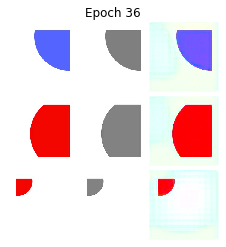

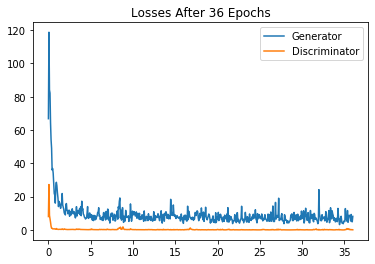

Epoch: 0037, Gen Loss: 5.9612, Discrim Loss: 0.1729, Discrim Acc: 0.8336


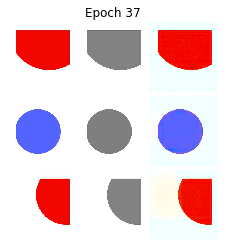

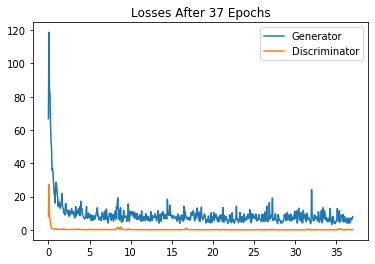

Epoch: 0038, Gen Loss: 6.8187, Discrim Loss: 0.0661, Discrim Acc: 0.9351


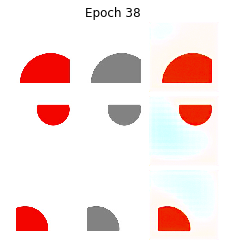

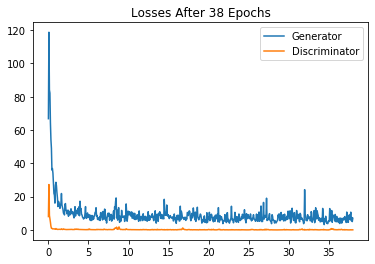

Epoch: 0039, Gen Loss: 9.1018, Discrim Loss: 0.1239, Discrim Acc: 0.8860


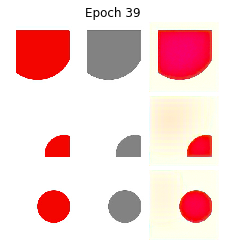

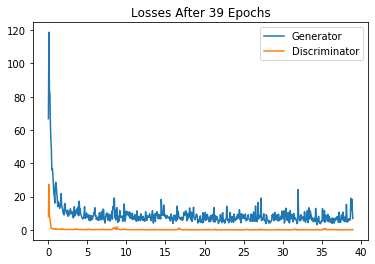

Epoch: 0040, Gen Loss: 6.7749, Discrim Loss: 0.0763, Discrim Acc: 0.9214


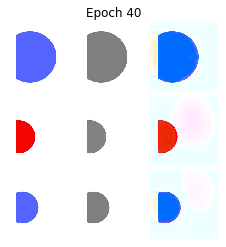

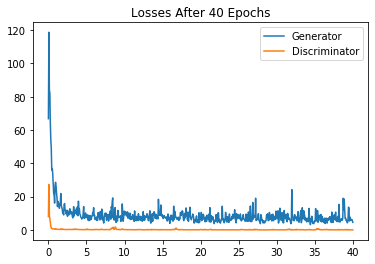

Epoch: 0041, Gen Loss: 8.3885, Discrim Loss: 0.0666, Discrim Acc: 0.9375


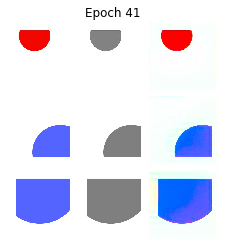

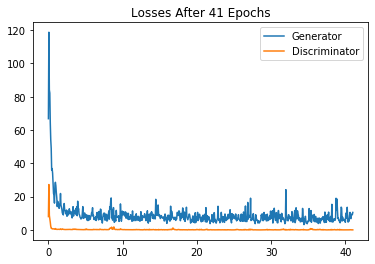

Epoch: 0042, Gen Loss: 7.1681, Discrim Loss: 0.0516, Discrim Acc: 0.9554


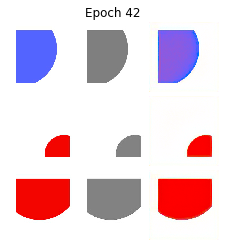

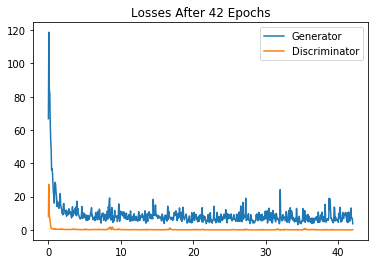

Epoch: 0043, Gen Loss: 7.3176, Discrim Loss: 0.1861, Discrim Acc: 0.8580


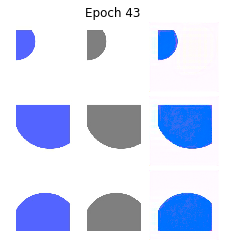

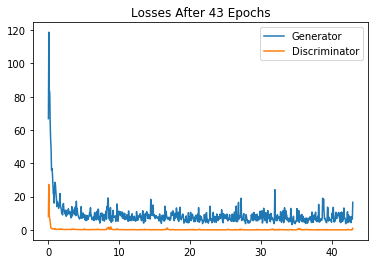

Epoch: 0044, Gen Loss: 7.9696, Discrim Loss: 0.3985, Discrim Acc: 0.7352


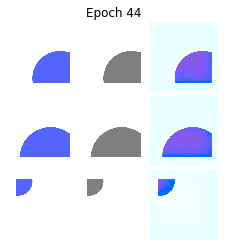

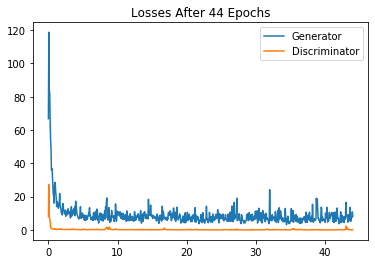

Epoch: 0045, Gen Loss: 8.6486, Discrim Loss: 0.1030, Discrim Acc: 0.8840


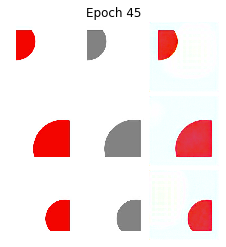

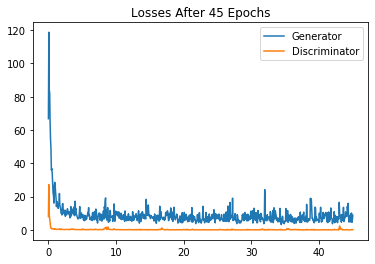

Epoch: 0046, Gen Loss: 7.3555, Discrim Loss: 0.0585, Discrim Acc: 0.9464


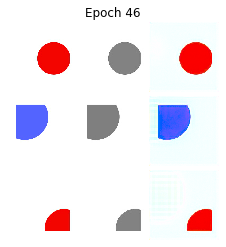

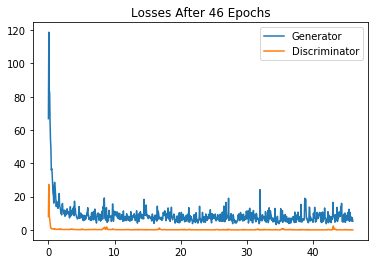

Epoch: 0047, Gen Loss: 7.8392, Discrim Loss: 0.1100, Discrim Acc: 0.8764


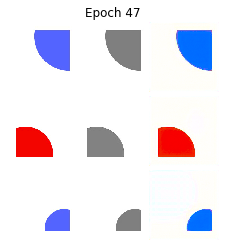

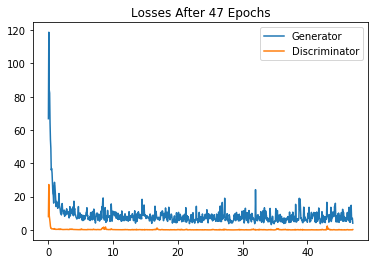

Epoch: 0048, Gen Loss: 6.7341, Discrim Loss: 0.4443, Discrim Acc: 0.6894


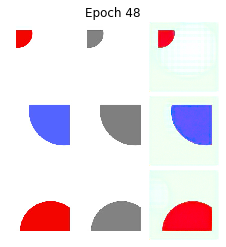

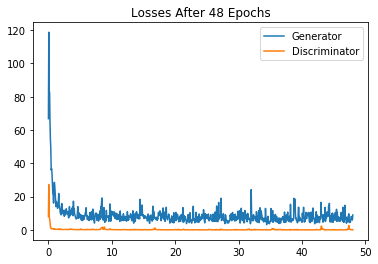

Epoch: 0049, Gen Loss: 6.5668, Discrim Loss: 0.0789, Discrim Acc: 0.9168


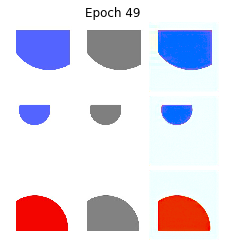

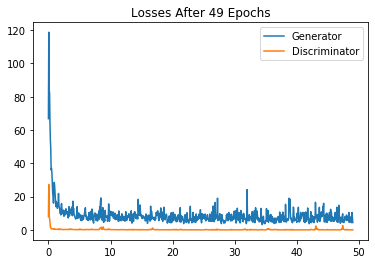

Epoch: 0050, Gen Loss: 7.0733, Discrim Loss: 0.1100, Discrim Acc: 0.8732


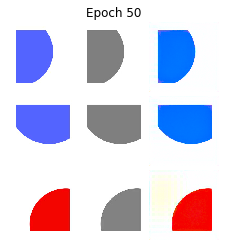

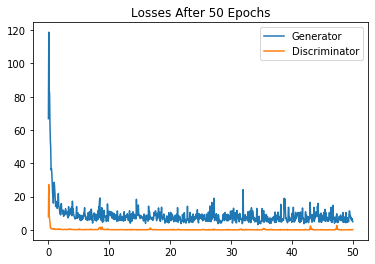

Epoch: 0051, Gen Loss: 8.2160, Discrim Loss: 0.1143, Discrim Acc: 0.8690


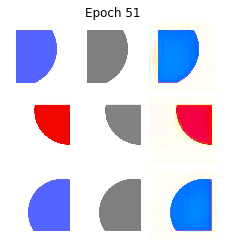

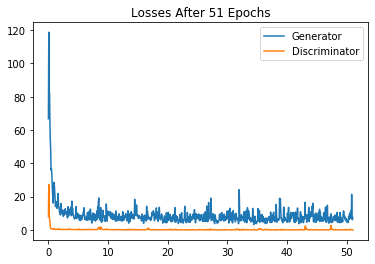

Epoch: 0052, Gen Loss: 5.9381, Discrim Loss: 0.0267, Discrim Acc: 0.9895


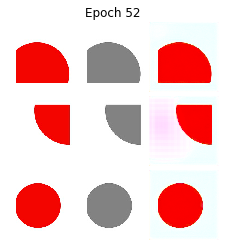

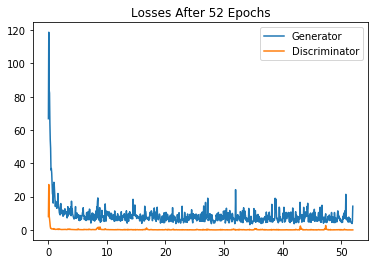

Epoch: 0053, Gen Loss: 7.3830, Discrim Loss: 0.0646, Discrim Acc: 0.9475


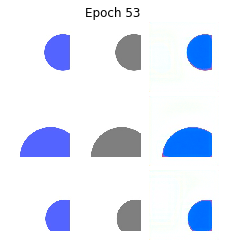

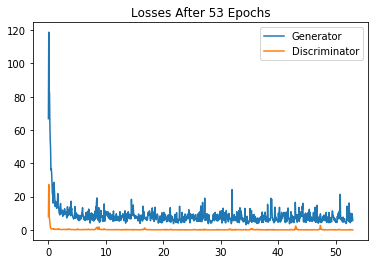

Epoch: 0054, Gen Loss: 7.1128, Discrim Loss: 0.0672, Discrim Acc: 0.9432


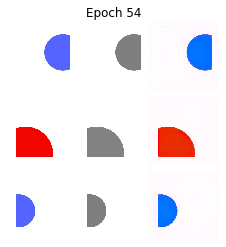

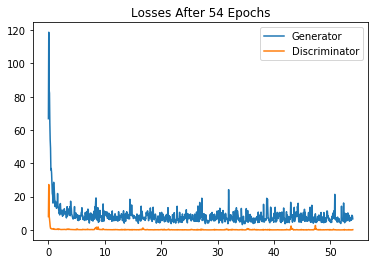

Epoch: 0055, Gen Loss: 5.7386, Discrim Loss: 0.0782, Discrim Acc: 0.9311


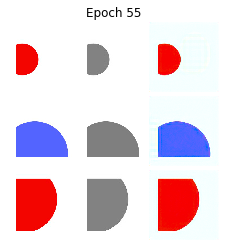

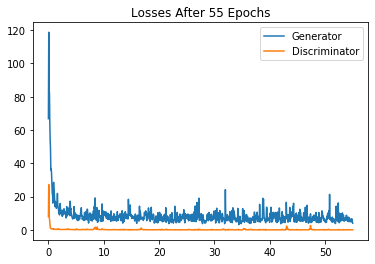

Epoch: 0056, Gen Loss: 6.4110, Discrim Loss: 0.1195, Discrim Acc: 0.8880


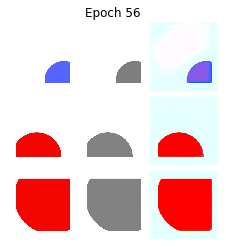

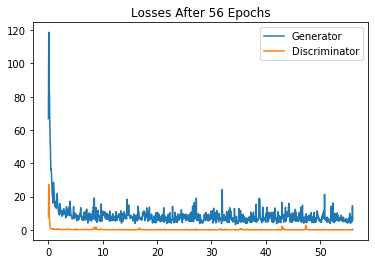

Epoch: 0057, Gen Loss: 6.5172, Discrim Loss: 0.3269, Discrim Acc: 0.6934


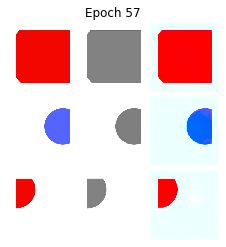

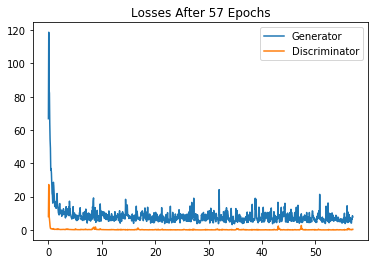

Epoch: 0058, Gen Loss: 8.8062, Discrim Loss: 0.0437, Discrim Acc: 0.9763


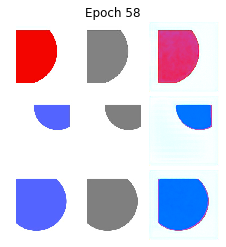

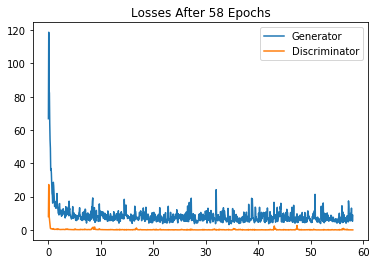

Epoch: 0059, Gen Loss: 7.5497, Discrim Loss: 0.0323, Discrim Acc: 0.9781


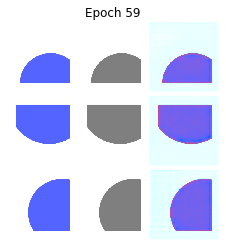

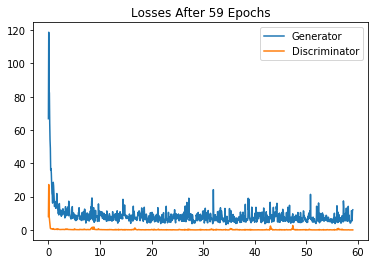

Epoch: 0060, Gen Loss: 6.6772, Discrim Loss: 0.0534, Discrim Acc: 0.9622


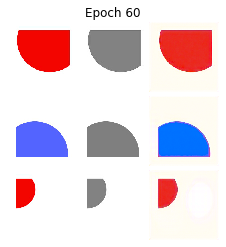

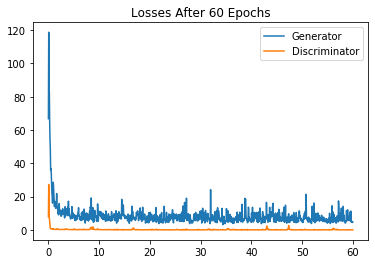

Epoch: 0061, Gen Loss: 6.8632, Discrim Loss: 0.0557, Discrim Acc: 0.9452


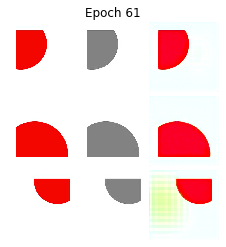

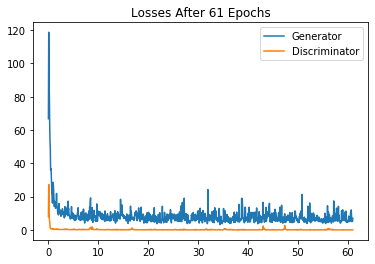

Epoch: 0062, Gen Loss: 7.7865, Discrim Loss: 0.0535, Discrim Acc: 0.9521


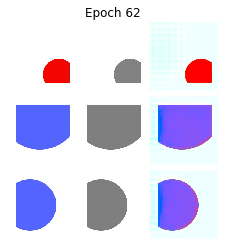

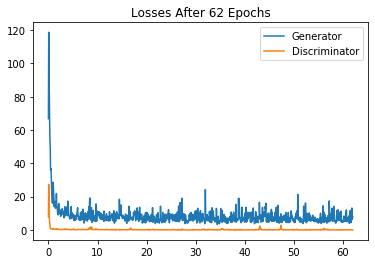

Epoch: 0063, Gen Loss: 7.1188, Discrim Loss: 0.0411, Discrim Acc: 0.9685


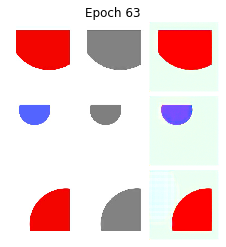

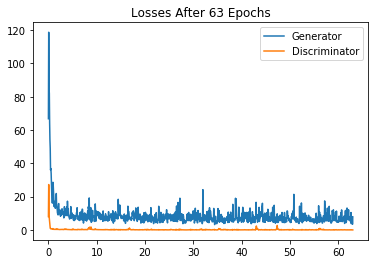

Epoch: 0064, Gen Loss: 7.0284, Discrim Loss: 0.0389, Discrim Acc: 0.9708


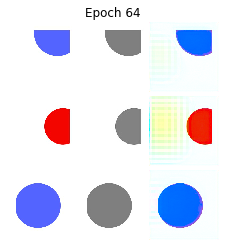

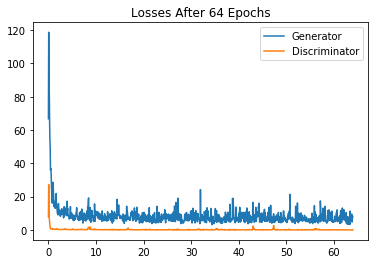

Epoch: 0065, Gen Loss: 7.1982, Discrim Loss: 0.1348, Discrim Acc: 0.8682


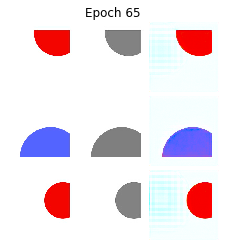

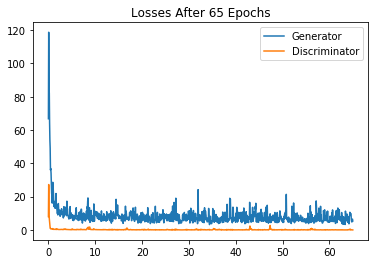

Epoch: 0066, Gen Loss: 8.0157, Discrim Loss: 0.0631, Discrim Acc: 0.9392


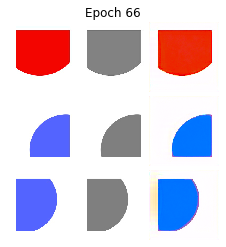

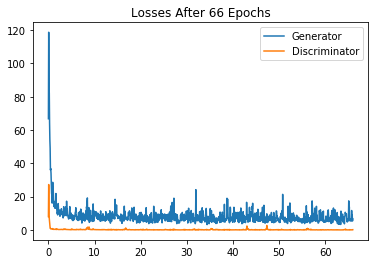

Epoch: 0067, Gen Loss: 6.5585, Discrim Loss: 0.2825, Discrim Acc: 0.8375


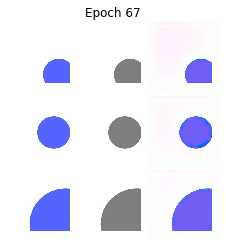

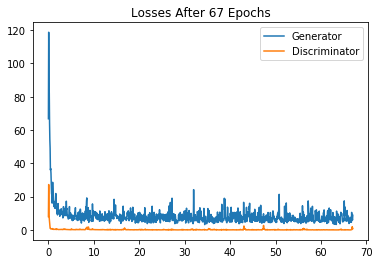

Epoch: 0068, Gen Loss: 7.0566, Discrim Loss: 0.1091, Discrim Acc: 0.8979


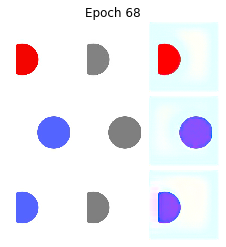

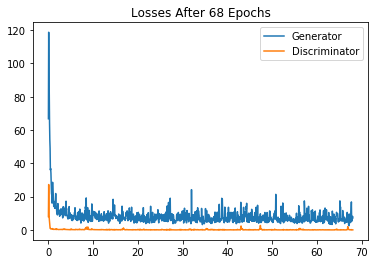

Epoch: 0069, Gen Loss: 6.1440, Discrim Loss: 0.0768, Discrim Acc: 0.9173


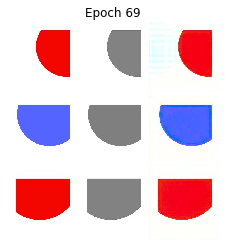

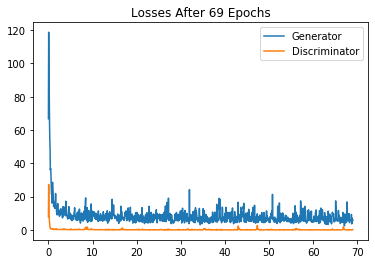

Epoch: 0070, Gen Loss: 6.5731, Discrim Loss: 0.0680, Discrim Acc: 0.9276


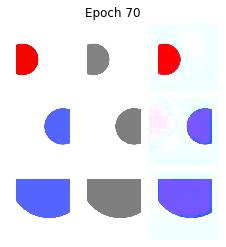

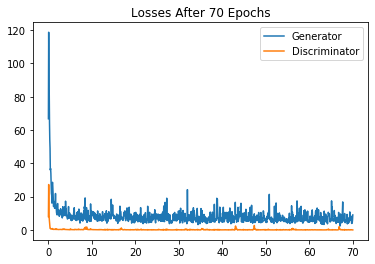

Epoch: 0071, Gen Loss: 6.7350, Discrim Loss: 0.0765, Discrim Acc: 0.9394


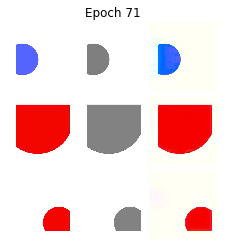

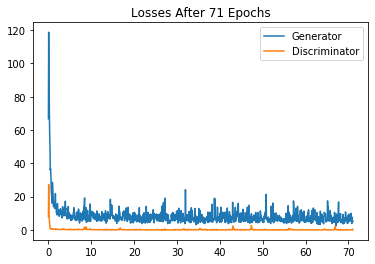

Epoch: 0072, Gen Loss: 6.9081, Discrim Loss: 0.0749, Discrim Acc: 0.9326


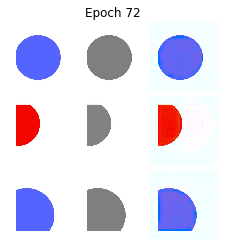

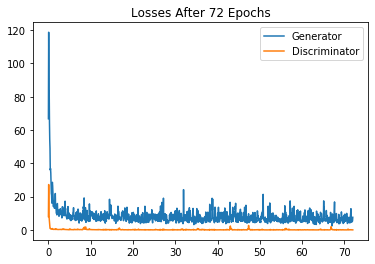

Epoch: 0073, Gen Loss: 6.7712, Discrim Loss: 0.1225, Discrim Acc: 0.8760


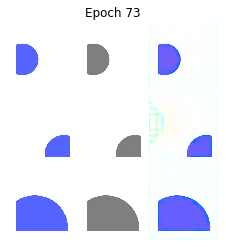

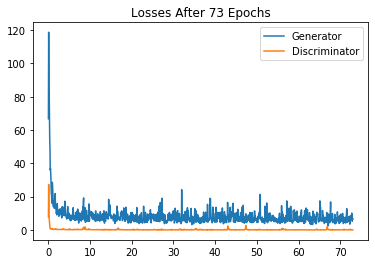

Epoch: 0074, Gen Loss: 6.0498, Discrim Loss: 0.0698, Discrim Acc: 0.9337


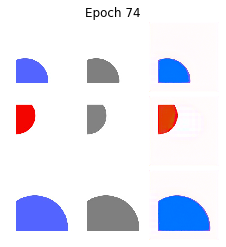

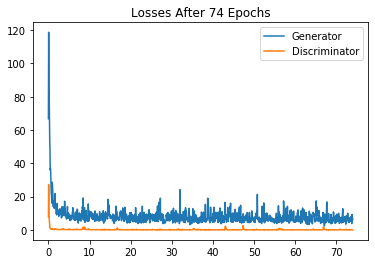

Epoch: 0075, Gen Loss: 7.7962, Discrim Loss: 0.1369, Discrim Acc: 0.8514


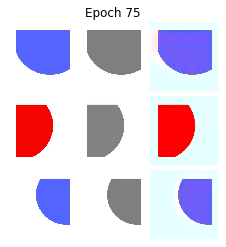

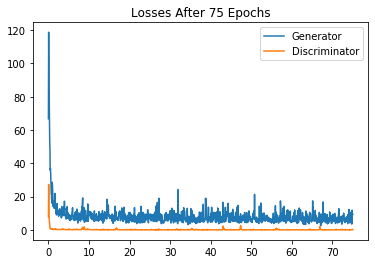

Epoch: 0076, Gen Loss: 6.7890, Discrim Loss: 0.0656, Discrim Acc: 0.9360


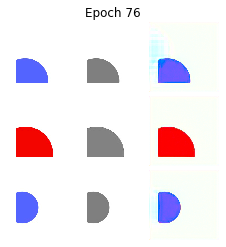

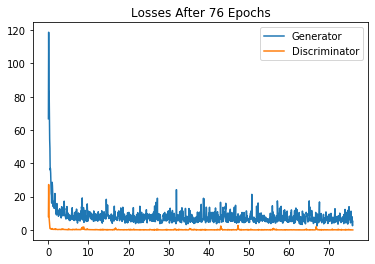

Epoch: 0077, Gen Loss: 7.3379, Discrim Loss: 0.0244, Discrim Acc: 0.9896


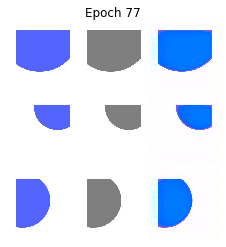

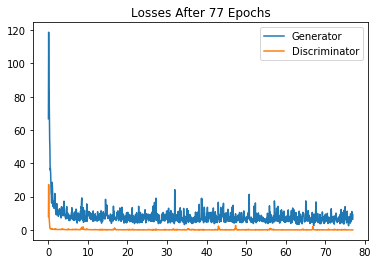

Epoch: 0078, Gen Loss: 6.8438, Discrim Loss: 0.1661, Discrim Acc: 0.8417


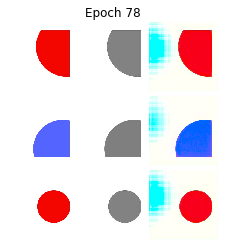

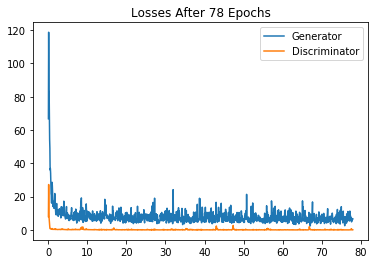

Epoch: 0079, Gen Loss: 6.3058, Discrim Loss: 0.1231, Discrim Acc: 0.8682


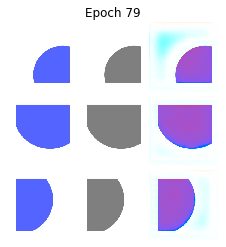

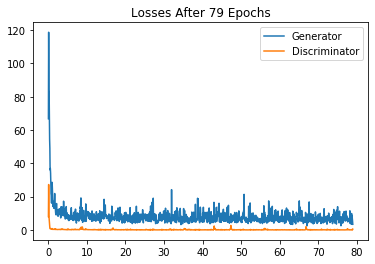

Epoch: 0080, Gen Loss: 5.7952, Discrim Loss: 0.0790, Discrim Acc: 0.9177


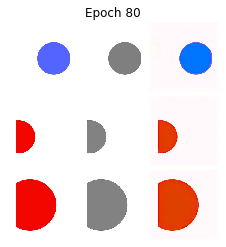

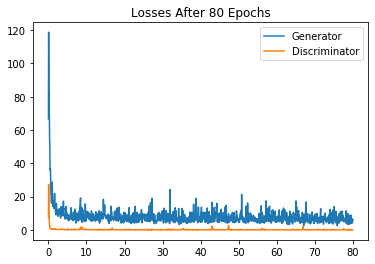

Epoch: 0081, Gen Loss: 5.9861, Discrim Loss: 0.0465, Discrim Acc: 0.9646


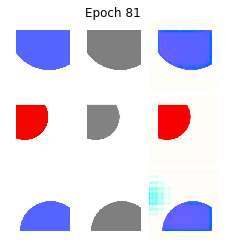

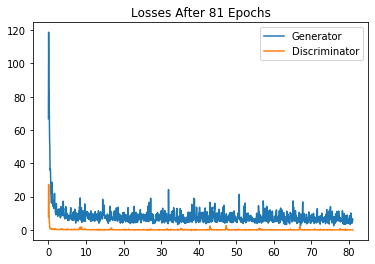

Epoch: 0082, Gen Loss: 6.6525, Discrim Loss: 0.0936, Discrim Acc: 0.9206


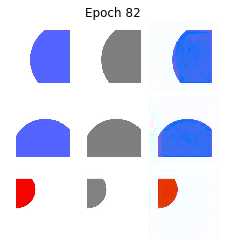

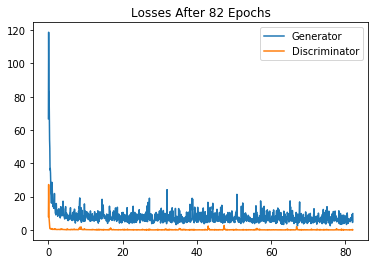

Epoch: 0083, Gen Loss: 6.7951, Discrim Loss: 0.2697, Discrim Acc: 0.7702


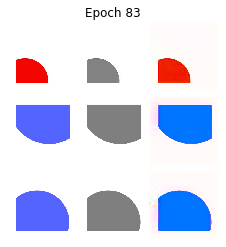

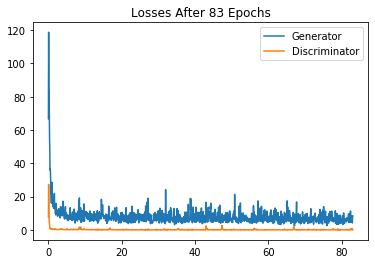

Epoch: 0084, Gen Loss: 6.7461, Discrim Loss: 0.0662, Discrim Acc: 0.9381


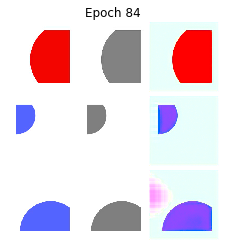

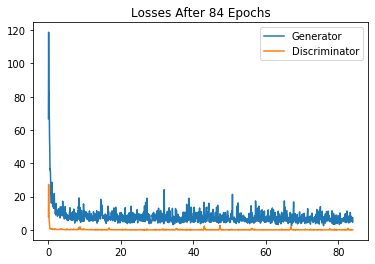

Epoch: 0085, Gen Loss: 7.1433, Discrim Loss: 0.1028, Discrim Acc: 0.9132


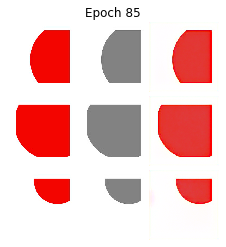

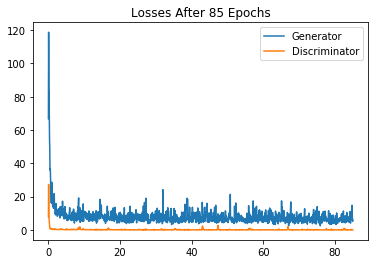

Epoch: 0086, Gen Loss: 6.9324, Discrim Loss: 0.0699, Discrim Acc: 0.9419


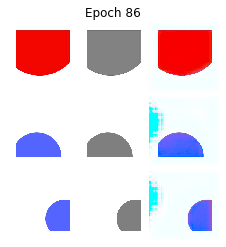

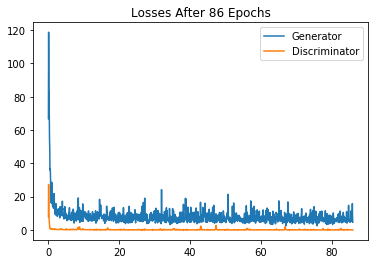

Epoch: 0087, Gen Loss: 6.6842, Discrim Loss: 0.0561, Discrim Acc: 0.9481


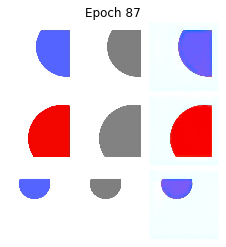

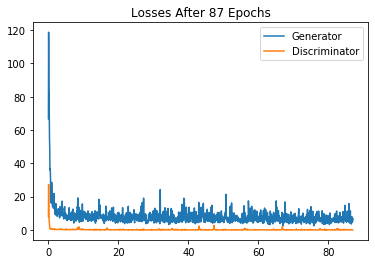

Epoch: 0088, Gen Loss: 7.1458, Discrim Loss: 0.0378, Discrim Acc: 0.9679


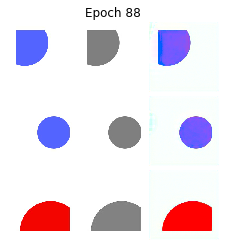

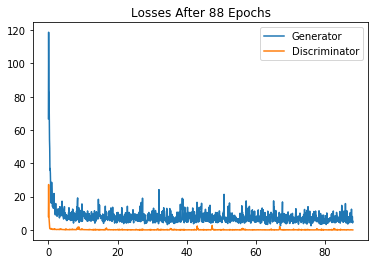

Epoch: 0089, Gen Loss: 5.9825, Discrim Loss: 0.1308, Discrim Acc: 0.8996


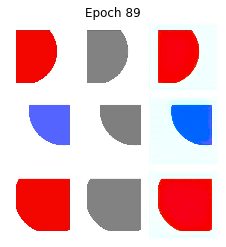

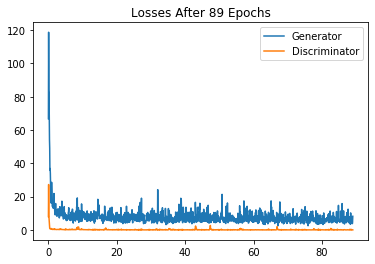

Epoch: 0090, Gen Loss: 7.3548, Discrim Loss: 0.2978, Discrim Acc: 0.7135


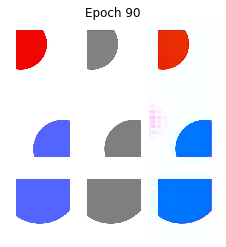

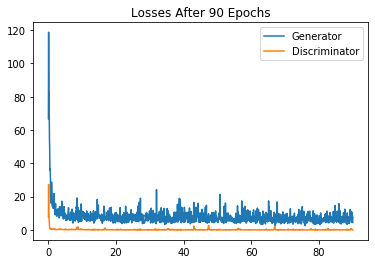

Epoch: 0091, Gen Loss: 6.6279, Discrim Loss: 0.0797, Discrim Acc: 0.9263


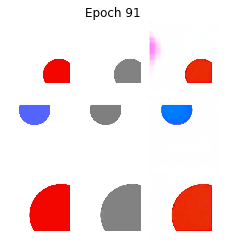

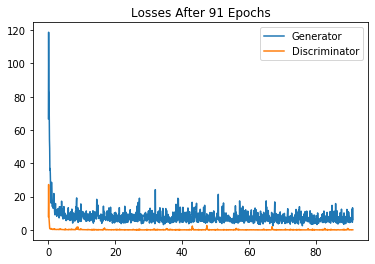

Epoch: 0092, Gen Loss: 6.7305, Discrim Loss: 0.4808, Discrim Acc: 0.7226


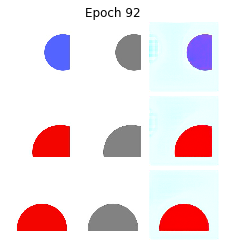

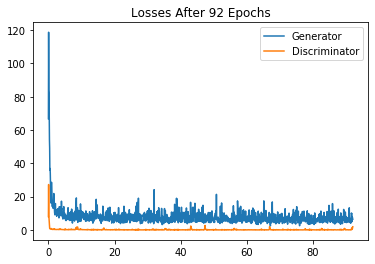

Epoch: 0093, Gen Loss: 6.6077, Discrim Loss: 0.3323, Discrim Acc: 0.7072


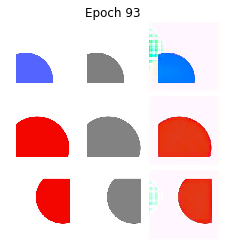

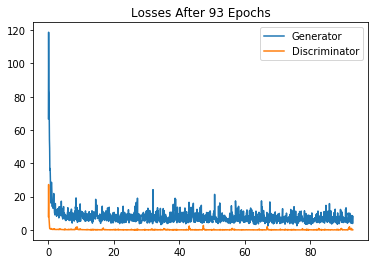

Epoch: 0094, Gen Loss: 6.6622, Discrim Loss: 0.0677, Discrim Acc: 0.9341


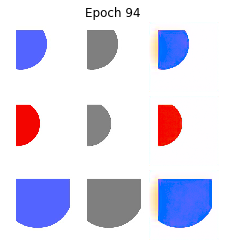

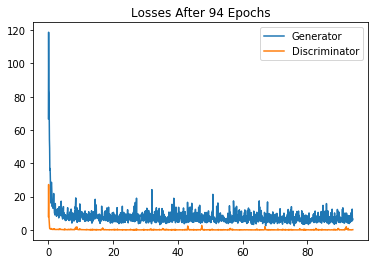

Epoch: 0095, Gen Loss: 6.7828, Discrim Loss: 0.0829, Discrim Acc: 0.9077


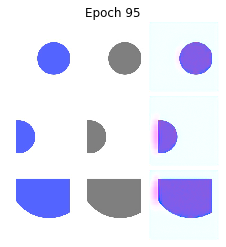

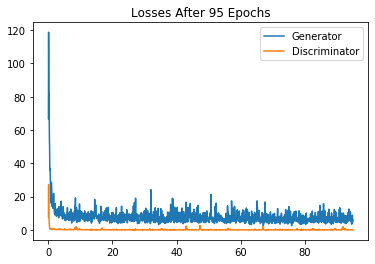

Epoch: 0096, Gen Loss: 5.4477, Discrim Loss: 0.1563, Discrim Acc: 0.8337


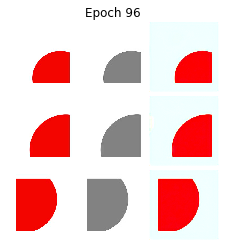

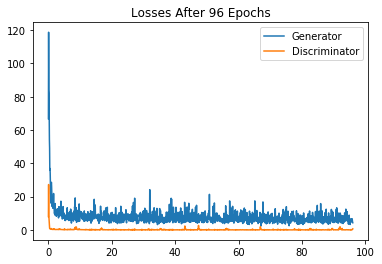

Epoch: 0097, Gen Loss: 6.2368, Discrim Loss: 0.0632, Discrim Acc: 0.9410


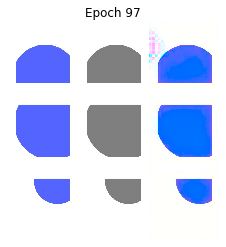

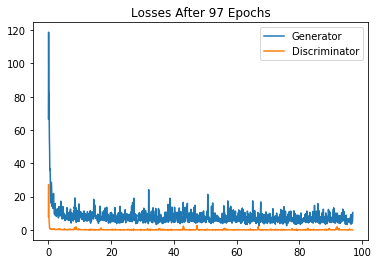

Epoch: 0098, Gen Loss: 6.0960, Discrim Loss: 0.0654, Discrim Acc: 0.9394


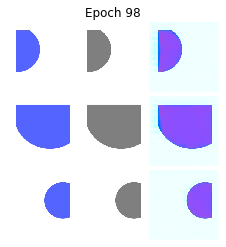

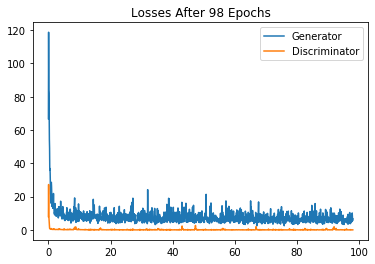

Epoch: 0099, Gen Loss: 5.6056, Discrim Loss: 0.0304, Discrim Acc: 0.9892


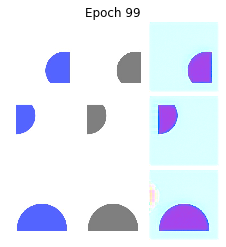

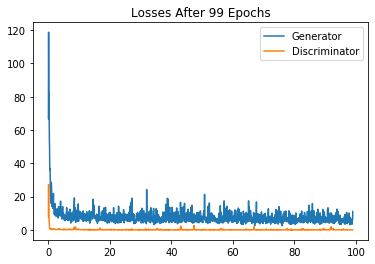

Epoch: 0100, Gen Loss: 5.8853, Discrim Loss: 0.1919, Discrim Acc: 0.8253


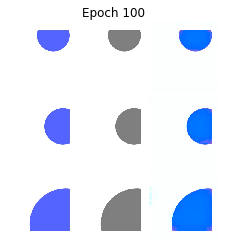

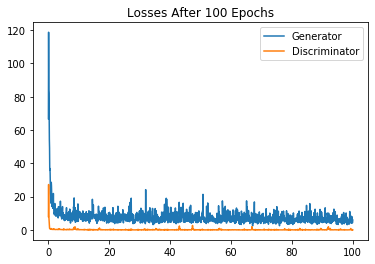

In [16]:
N_EPOCHS = 100

g_losses = []
d_losses = []
d_accuracies = []

# PatchGAN loss ground truths
true_labels = np.ones((BATCH_SIZE, patch, patch, 1))
fake_labels = np.zeros((BATCH_SIZE, patch, patch, 1))

for epoch in tqdm_notebook(range(N_EPOCHS), desc="Training GAN..."):

    cum_d_loss = 0.
    cum_g_loss = 0.
    cum_d_acc = 0.

    pbar_message = "Epoch " + str(epoch + 1)
    for batch_idx in tqdm_notebook(range(num_batches), desc=pbar_message):
        # Random indices for training examples
        idx = randint(0, y_train.shape[0], BATCH_SIZE)

        # X is L channel, Y is AB
        # Get the next set of real images to be used in this iteration
        ab_channel = y_train[idx]
        # Get the next set of labels (grayscale images to be used in this iteration)
        l_channel = X_train[idx]

        noise_data = generate_noise(BATCH_SIZE, 100)

        # Generate fake AB channels from L
        fake_ab = generator.predict([noise_data, l_channel])

        # Train discriminator on fake and real data
        d_loss_fake, d_acc_fake = discriminator.train_on_batch([fake_ab, l_channel], fake_labels)
        d_loss_true, d_acc_true = discriminator.train_on_batch([ab_channel, l_channel], true_labels)
        d_loss = (d_loss_fake + d_loss_true) / 2
        d_acc = (d_acc_fake + d_acc_true) / 2
        
        cum_d_loss += d_loss
        cum_d_acc += d_acc

        # Train generator (by way of the whole gan)
        # Note that there are 3 losses. The first should be the
        # weighted sum of the adversarial and L1 loss values for the batch.
        # Ref: https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/
        g_loss, _, _ = gan.train_on_batch([noise_data, l_channel], [ab_channel, true_labels])
        cum_g_loss += g_loss

        g_losses.append(g_loss)
        d_losses.append(d_loss)
        d_accuracies.append(d_acc)

    print('Epoch: {:04d}, Gen Loss: {:0.4f}, Discrim Loss: {:0.4f}, Discrim Acc: {:0.4f}'.format(
        epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches, cum_d_acc/num_batches))
    sample_images(ab_channel, l_channel, fake_ab, 3, True, epoch+1)

    plot_losses(g_losses, d_losses, epoch + 1)

gan.save_weights(save_path +'GAN_Weights.h5')
discriminator.save_weights(save_path + 'Discriminator_Weights.h5')